This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fchatelaf%2Fml-sicom3a/master?urlpath=lab/tree/notebooks/5bis_linear_models_lasso_logistic/)

## Load the *Advertising* Data Set

Sales (in thousands of units) for a particular product and Advertising budgets (in thousands of dollars) of the product for television, radio and newspapers. The purpose of the regression is to predict the `Sales` (target variable) based on the three variables `TV`, `Radio` and `Newspaper` which measure advertising budgets for each media respectively.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load in the Advertising data set
df = pd.read_csv('Advertising.csv')
# Data distribution
print('Summary statistics')
df.describe()

Summary statistics


,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [2]:
X = df.drop('Sales', axis=1) # TV, Radio and Newspaper variables only
y = df['Sales'] # response
print(X.shape) # data dimensions: n (sample size) x p (dimension size)

(200, 3)


## Apply linear regression on the original dataset

In [3]:
from sklearn.model_selection import train_test_split

# Split data -> 1/2 for learning & 1/2 for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=0)
print('Training set dimensions: {}\n'.format(X_train.shape)) # training set dimensions: n (sample size) x p (dimension size)

# Apply linear regression
from sklearn.linear_model import LinearRegression
linrgr =  LinearRegression()
linrgr.fit(X_train, y_train)

# Get the estimated weights
df_weights = pd.DataFrame.from_records( linrgr.coef_.reshape(1,-1), columns=X.columns, index=['Estimated Weights'])
print(df_weights)

# Get the coefficient of determination R2
r2 = linrgr.score(X_test,y_test)
print("\nLinear model explains {:.0f}% of the Sales variance".format(100*r2))

Training set dimensions: (50, 3)

                         TV     Radio  Newspaper
Estimated Weights  0.043334  0.207149   0.007986

Linear model explains 88% of the Sales variance


**Exercise:**
- Does the linear model seems accurate for this task and dataset?
- What are the most significant variables to predict scale (*hint*: you may scale the training data if you want to be sure to correctly intepret the weight)

## Curse of dimensionality 

We now add  a large number of noisy (i.e. not correlated to the target) data to the features, and we observe the resulting performances for different regression methods

In [4]:
from sklearn.preprocessing import StandardScaler 

# Select random seed
np.random.seed(1)

# Generate the noisy variables 
p_noise = 30 # number of noisy data to add
X_noisy = X.copy()
E = np.random.randn(len(y), p_noise)
# Add the noisy data at the end of the informative features
for i in range(p_noise):
    X_noisy.insert(loc=len(X_noisy.columns), column='noise_'+str(i), value = E[:,i])
    
# labels of the informative and noisy variables
var_names = X_noisy.columns

# normalize the data
scaler = StandardScaler()
X_noisy = scaler.fit_transform(X_noisy)

# Split data -> 1/2 for learning & 1/2 for validation
X_train, X_test, y_train, y_test = train_test_split(X_noisy, y, test_size=0.75, random_state=0)
print(X_train.shape) # training set dimensions: n (sample size) x p (dimension size)

(50, 33)


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Init regressors
regressors = [LinearRegression(), SVR(kernel='linear'), KNeighborsRegressor(), RandomForestRegressor(n_estimators=10)]
names = ["Linear Regression", "Support Vector Machines", "K Nearest Neighbors",  "Random Forest Regressor"]

for rgr, name in zip(regressors, names):
    rgr.fit(X_train, y_train)
    y_pred = rgr.predict(X_test) # predict the label of X_test from X_train and y_train
    r2 = r2_score(y_test, y_pred) # Compute the overall accuracy
    print('Coef. of Determination R2 for {1}: \t {0:.2f}'.format(r2,name))

Coef. of Determination R2 for Linear Regression: 	 0.42
Coef. of Determination R2 for Support Vector Machines: 	 0.60
Coef. of Determination R2 for K Nearest Neighbors: 	 0.28
Coef. of Determination R2 for Random Forest Regressor: 	 0.81


**Exercise:**
- Does the methods without regularization work well  on this high dimensional and noisy data?

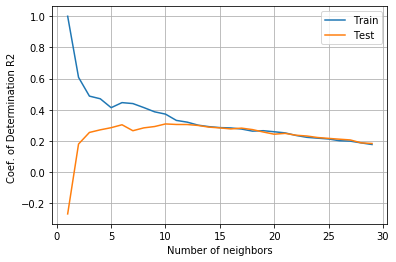

In [6]:
# Optimize the number of neighbors in knn 
neighbors = np.arange(1,30)
errors_train, errors_validation = [], []
for n_ in neighbors:
    knn = KNeighborsRegressor(n_neighbors=n_)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_train)
    errors_train.append(r2_score(y_train, y_pred))
    
    y_pred = knn.predict(X_test)
    errors_validation.append(r2_score(y_test, y_pred))
    
plt.plot(neighbors,np.asarray(errors_train))
plt.plot(neighbors,np.asarray(errors_validation))
plt.legend(["Train", "Test"])
plt.xlabel("Number of neighbors")
plt.ylabel("Coef. of Determination R2 ")
plt.grid()

**Exercise:**
- Does the knn regressor based on euclidean metric seems accurate for this task and dataset? How can we explain that?

## Regularization and Variable selection

In [7]:
# Make Lasso Regression
from sklearn.linear_model import LassoCV

lassoCV = LassoCV(cv=5)
lassoCV.fit(X_train, y_train)
alpha_best = lassoCV.alpha_

y_pred = lassoCV.predict(X_test) # predict the label of X_test from X_train and y_train
r2 = r2_score(y_test, y_pred) # Compute the overall accuracy
print('Coef. of Determination R2 for penalized Log Reg: \t {0:.2f}'.format(r2,name))

Coef. of Determination R2 for penalized Log Reg: 	 0.88


In [8]:
# Get the Lasso estimated weights
df_weights = pd.DataFrame.from_records(lassoCV.coef_.reshape(1,-1).copy(), 
                                       columns=var_names, 
                                       index=['Estimated Weights'])
pd.pandas.set_option('display.max_columns', None)
print(df_weights)

                         TV     Radio  Newspaper  noise_0  noise_1  noise_2  \
Estimated Weights  3.339027  2.763272        0.0      0.0     -0.0     -0.0   

                   noise_3  noise_4  noise_5  noise_6  noise_7  noise_8  \
Estimated Weights     -0.0     -0.0     -0.0     -0.0      0.0      0.0   

                   noise_9  noise_10  noise_11  noise_12  noise_13  noise_14  \
Estimated Weights     -0.0       0.0      -0.0       0.0      -0.0       0.0   

                   noise_15  noise_16  noise_17  noise_18  noise_19  noise_20  \
Estimated Weights       0.0  0.088921       0.0       0.0 -0.004513       0.0   

                   noise_21  noise_22  noise_23  noise_24  noise_25  noise_26  \
Estimated Weights      -0.0      -0.0      -0.0      -0.0      -0.0      -0.0   

                   noise_27  noise_28  noise_29  
Estimated Weights       0.0      -0.0       0.0  


**Exercise:**
- Does the lasso regression works well on this high dimensional and noisy data?
- Does it suceed in recovering the significant features?

## Show Lasso path

In [9]:
from sklearn.linear_model import Lasso
# warning: don't use lasso_path() or lars_path() that appear to 
# be bugged (on my install).  

lasso = Lasso()
lasso.fit(X_train, y_train)
# useful values for the regularization parameter (log-scale)
alphas = alpha_best * np.logspace(4, -.5, 100)
# lasso path for the weights
coefs_ = []
beta_l1norm = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    beta_l1norm.append(np.sum(np.abs(lasso.coef_.ravel()))) 
    coefs_.append(lasso.coef_.ravel().copy())
betas = np.array(coefs_)

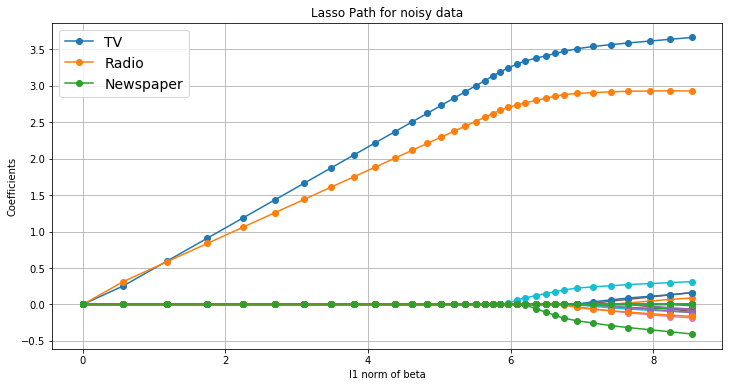

In [10]:
# Display lasso path Vs l1 norm of the coeff vector
plt.figure(figsize=(12,6))
plt.plot(beta_l1norm, betas, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('l1 norm of beta')
plt.ylabel('Coefficients')
plt.title('Lasso Path for noisy data')
plt.axis('tight')
plt.legend(var_names[:3], fontsize=14)
plt.grid('On')
plt.show()

**Exercise:**
- What are the two most significant variables according to the Lasso Path?